# Wrangling and Analyzing WeRateDogs Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from timeit import default_timer as timer
from datetime import datetime
import tweepy 
from tweepy import OAuthHandler
import json 
import re
import seaborn as sns

# Gathering Data

In [3]:
# load twitter archive csv file
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")
twitter_archive.set_index("tweet_id", inplace = True)

In [4]:
twitter_archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
#URL programatically downloaded
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
with open('image-predictions.tsv' , 'wb') as file:
    predictions = requests.get(url)
    file.write(predictions.content)

# load image predictions
image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')
image_prediction.set_index("tweet_id", inplace = True)

In [6]:
image_prediction.head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
### These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

### NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
### df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
### change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
### NOTE TO REVIEWER: this student had mobile verification issues so the following
### Twitter API code was sent to this student from a Udacity instructor
### Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = df_1.tweet_id.values
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
### Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
api_data = []

#read the created file
with open("tweet_json.txt", "r") as f:
    for line in f:
        tweet = json.loads(line)           
        api_data.append({"tweet_id": tweet["id"],"retweet_count": tweet["retweet_count"],"favorite_count": tweet["favorite_count"],"retweeted": tweet["retweeted"]}) 
tweet_api = pd.DataFrame(api_data, columns = ["tweet_id", "retweet_count", "favorite_count", "retweeted"])
tweet_api.set_index("tweet_id", inplace = True)

In [8]:
tweet_api.head()

,retweet_count,favorite_count,retweeted
tweet_id,,,
892420643555336193,8853,39467,False
892177421306343426,6514,33819,False
891815181378084864,4328,25461,False
891689557279858688,8964,42908,False
891327558926688256,9774,41048,False


# Assessing Data

In [9]:
twitter_archive.sample(5)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
818145370475810820,NaN,NaN,2017-01-08 17:20:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Autumn. Her favorite toy is a cheesebu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818145370...,11,10,Autumn,None,None,None,None
760290219849637889,NaN,NaN,2016-08-02 01:44:48 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Rocco. He's doing his best. 13/10 some...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760290219...,13,10,Rocco,None,None,None,None
714606013974974464,NaN,NaN,2016-03-29 00:12:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here are two lil cuddly puppers. Both 12/10 wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714606013...,12,10,None,None,None,None,None
678675843183484930,NaN,NaN,2015-12-20 20:38:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Exotic pup here. Tail long af. Throat looks sw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678675843...,2,10,None,None,None,None,None
836648853927522308,NaN,NaN,2017-02-28 18:46:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @SchafeBacon2016: @dog_rates Slightly distu...,8.366481e+17,7.124572e+17,2017-02-28 18:43:57 +0000,https://twitter.com/SchafeBacon2016/status/836...,11,10,None,None,None,None,None


In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), object(10)
memory usa

In [11]:
twitter_archive.isnull().sum()

in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [12]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Tucker       10
Lola         10
Penny        10
Bo            9
Winston       9
Sadie         8
the           8
Daisy         7
Toby          7
Buddy         7
an            7
Bailey        7
Scout         6
Dave          6
Jack          6
Rusty         6
Milo          6
Bella         6
Jax           6
Koda          6
Stanley       6
Leo           6
Oscar         6
Louis         5
           ... 
Dallas        1
Butters       1
Roscoe        1
Callie        1
Berkeley      1
Howie         1
Colin         1
Darby         1
Chevy         1
this          1
Jett          1
Socks         1
Hall          1
Wesley        1
Claude        1
Holly         1
Superpup      1
Craig         1
Timofy        1
Aqua          1
Storkson      1
Tilly         1
Blu           1
Boots         1
Clyde         1
Bert          1
Tove          1
Vinscent      1
Ozzie         1
Lizzie        1
Name: name, Length: 957,

In [13]:
twitter_archive['doggo'].unique()

array(['None', 'doggo'], dtype=object)

In [14]:
twitter_archive['floofer'].unique()

array(['None', 'floofer'], dtype=object)

In [15]:
twitter_archive['pupper'].unique()

array(['None', 'pupper'], dtype=object)

In [16]:
twitter_archive['puppo'].unique()

array(['None', 'puppo'], dtype=object)

In [17]:
twitter_archive['rating_denominator'].describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [18]:
twitter_archive['rating_numerator'].describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [19]:
# pandas settings
pd.set_option('display.max_colwidth', -1)
twitter_archive.sample(5)[['text','expanded_urls']]

,text,expanded_urls
tweet_id,,
746507379341139972,This is Shiloh. She did not pass the soft mouth egg test. 10/10 would absolutely still pet https://t.co/PlR6hjqvr5,"https://twitter.com/dog_rates/status/746507379341139972/photo/1,https://twitter.com/dog_rates/status/746507379341139972/photo/1"
718613305783398402,This is Carper. He's a Tortellini Angiosperm. In desperate need of a petting. 11/10 would hug softly https://t.co/lK9YDkRzPj,https://twitter.com/dog_rates/status/718613305783398402/photo/1
681242418453299201,This is Champ. He's being sacrificed to the Aztec sun god Huitzilopochtli. So sad. 10/10 Champ doesn't deserve this https://t.co/VGsziXImoy,https://twitter.com/dog_rates/status/681242418453299201/photo/1
670474236058800128,Honor to rate this dog. Great teeth. Nice horns. Unbelievable posture. Fun to pet. Big enough to ride. 10/10 rad dog https://t.co/7JMAHdJ6A4,https://twitter.com/dog_rates/status/670474236058800128/photo/1
792773781206999040,This is Monster. Not an actual monster tho. He's showing you his tongue. Very impressive Monster. 12/10 would snug https://t.co/RhaPExuxJL,https://twitter.com/dog_rates/status/792773781206999040/photo/1


In [20]:
twitter_archive[twitter_archive.expanded_urls.str.contains(',', na = False)]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1",13,10,Koda,None,None,None,None
889638837579907072,NaN,NaN,2017-07-25 00:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist https://t.co/f8dEDcrKSR,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/889638837579907072/photo/1,https://twitter.com/dog_rates/status/889638837579907072/photo/1",12,10,Ted,None,None,None,None
888804989199671297,NaN,NaN,2017-07-22 16:56:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zeke. He has a new stick. Very proud of it. Would like you to throw it for him without taking it. 13/10 would do my best https://t.co/HTQ77yNQ5K,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/888804989199671297/photo/1,https://twitter.com/dog_rates/status/888804989199671297/photo/1",13,10,Zeke,None,None,None,None
888554962724278272,NaN,NaN,2017-07-22 00:23:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ralphus. He's powering up. Attempting maximum borkdrive. 13/10 inspirational af https://t.co/YnYAFCTTiK,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1",13,10,Ralphus,None,None,None,None
888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rat

In [21]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [22]:
twitter_archive[twitter_archive['rating_numerator'] == 1776]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


In [23]:
twitter_archive[twitter_archive['rating_denominator'] > 10].shape

(20, 16)

In [24]:
twitter_archive[twitter_archive['rating_denominator'] > 10]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None


In [25]:
twitter_archive[twitter_archive.text.str.contains("(\d+\.\d*\/\d+)", na = False)][['text', 'rating_numerator', 'rating_denominator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator,rating_denominator
tweet_id,,,
883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


## Quality and Tidiness issues:
   ### twitter_archive DF:
        - Columns doggo, floofer, pupper and puppo should be one column .
        - Expanded_urls column has 639 rows with multiple URLs separated with a ',' .
        - timestamp columns of type object .
        - remove unnecessary columns.
        - rating_numerator has not been correctly extracted from tweet .
        - rating_denominator value greater than 10 should be changed .
        - name of dogs contain "None", "the" and "a" .


In [26]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
jpg_url    2075 non-null object
img_num    2075 non-null int64
p1         2075 non-null object
p1_conf    2075 non-null float64
p1_dog     2075 non-null bool
p2         2075 non-null object
p2_conf    2075 non-null float64
p2_dog     2075 non-null bool
p3         2075 non-null object
p3_conf    2075 non-null float64
p3_dog     2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [27]:
image_prediction.sample(5)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
798628517273620480,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
691090071332753408,https://pbs.twimg.com/media/CZc-u7IXEAQHV1N.jpg,1,barrow,0.241637,False,tub,0.238450,False,bathtub,0.167285,False
730573383004487680,https://pbs.twimg.com/media/CiOEnI6WgAAmq4E.jpg,2,American_Staffordshire_terrier,0.810158,True,Labrador_retriever,0.058205,True,Weimaraner,0.027930,True
686377065986265092,https://pbs.twimg.com/media/CYaAS2kUoAINkye.jpg,1,German_shepherd,0.830816,True,Leonberg,0.076325,True,bloodhound,0.037449,True
670427002554466305,https://pbs.twimg.com/media/CU3VzVwWwAAAsst.jpg,1,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True


In [28]:
image_prediction.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
cocker_spaniel               30 
malamute                     30 
French_bulldog               26 
Chesapeake_Bay_retriever     23 
miniature_pinscher           23 
seat_belt                    22 
Siberian_husky               20 
German_shepherd              20 
Staffordshire_bullterrier    20 
Cardigan                     19 
web_site                     19 
Maltese_dog                  18 
beagle                       18 
Eskimo_dog                   18 
teddy                        18 
Shetland_sheepdog            18 
Lakeland_terrier             17 
Rottweiler                   17 
Shih-Tzu                     17 
Italian_greyhound            16 
kuvasz                       16 
          

In [29]:
image_prediction.jpg_url.value_counts().max()

2

In [30]:
image_prediction.query("p1_dog == False and p2_dog == False and p3_dog == False")

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False


## Quality and Tidiness issues:
   ### image_prediction DF:
        - p1, p2 and p3 are not all lowercase, some are uppercase .
        - p1 ,p2 and p3 columns have an underscore instead of a whitespace between the names .
        - p1_dog, p2_dog and p3_dog in some rows are all False .
        - jpg_url proove that there are duplicates in the dataframe .
        - 324 tweets their images do not contain any dogs .
        - rename columns .

In [31]:
tweet_api.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 892420643555336193 to 666020888022790149
Data columns (total 3 columns):
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
retweeted         2354 non-null bool
dtypes: bool(1), int64(2)
memory usage: 57.5 KB


## Tidiness issues:
        - All three dataframes should be merged together using the column tweet_id  .
        - Columns doggo, floofer, pupper and puppo shoud be one column (twitter_archive DF).
        
## Quality issues:
        - Expanded_urls column has 639 rows with multiple URLs seperated with a ',' (twitter_archive DF).
        - timestamp columns of type object (twitter_archive DF) .
        - remove unnecessary columns (twitter_archive DF).
        - rating_numerator have not been correctly extracted from tweet (twitter_archive DF) .
        - rating_denominator value greater than 10 should be changed (twitter_archive DF) .
        - name of dogs contain "None", "the" and "a" (twitter_archive DF) .
        - p1, p2 and p3 are not all lowercase, some are uppercase (image_prediction DF).
        - p1 ,p2 and p3 columns have an underscore instead of a whitespace between the names (image_prediction DF).
        - p1_dog, p2_dog and p3_dog in some rows are all False (image_prediction DF).
        - jpg_url proove that there are duplicates in the dataframe (image_prediction DF).
        - 324 tweets their images do not contain any dogs (image_prediction DF) .
        - rename columns (image_prediction DF) .


# Clean Data

### Define: All three tables should be merged together using column tweet_id
        - using function merge in pandas we will merge all three dataframes using column tweet_id and outer join so we wouldn't loose any rows.

In [32]:
df_merged = pd.merge(twitter_archive, image_prediction, on = "tweet_id", how = "outer")
df_merged = pd.merge(df_merged, tweet_api, on = "tweet_id", how = "outer")
df_merged_clean = df_merged.copy()
df_merged_clean.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,retweeted
tweet_id,,,,,,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,...,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,False
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,False
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0,False
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0,False
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774.0,41048.0,False


In [33]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 30 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       2075 non-null object


### Define: p1_dog, p2_dog and p3_dog in some rows are all False .
        - drop rows where p1_dog, p2_dog and p3_dog are all False

In [34]:
df_merged_clean.drop(df_merged_clean.query("p1_dog == False and p2_dog == False and p3_dog == False").index, inplace = True)

In [35]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 892177421306343426 to 666020888022790149
Data columns (total 30 columns):
in_reply_to_status_id         75 non-null float64
in_reply_to_user_id           75 non-null float64
timestamp                     2032 non-null object
source                        2032 non-null object
text                          2032 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 1973 non-null object
rating_numerator              2032 non-null int64
rating_denominator            2032 non-null int64
name                          2032 non-null object
doggo                         2032 non-null object
floofer                       2032 non-null object
pupper                        2032 non-null object
puppo                         2032 non-null object
jpg_url                       1751 non-null object


### Define: jpg_url proove that there are duplicates in the dataframe .
        - drop all rows with column jpg_url having a NaN value .

In [36]:
df_merged_clean.dropna(subset = ["jpg_url"], inplace = True)

In [37]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 892177421306343426 to 666020888022790149
Data columns (total 30 columns):
in_reply_to_status_id         20 non-null float64
in_reply_to_user_id           20 non-null float64
timestamp                     1751 non-null object
source                        1751 non-null object
text                          1751 non-null object
retweeted_status_id           65 non-null float64
retweeted_status_user_id      65 non-null float64
retweeted_status_timestamp    65 non-null object
expanded_urls                 1751 non-null object
rating_numerator              1751 non-null int64
rating_denominator            1751 non-null int64
name                          1751 non-null object
doggo                         1751 non-null object
floofer                       1751 non-null object
pupper                        1751 non-null object
puppo                         1751 non-null object
jpg_url                       1751 non-null object
img

### Define: remove unnecessary columns .
        - drop columns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp and retweeted.

In [38]:
df_merged_clean.drop(["in_reply_to_status_id", "in_reply_to_user_id","retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "retweeted"], inplace=True, axis = 1)

In [39]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 892177421306343426 to 666020888022790149
Data columns (total 24 columns):
timestamp             1751 non-null object
source                1751 non-null object
text                  1751 non-null object
expanded_urls         1751 non-null object
rating_numerator      1751 non-null int64
rating_denominator    1751 non-null int64
name                  1751 non-null object
doggo                 1751 non-null object
floofer               1751 non-null object
pupper                1751 non-null object
puppo                 1751 non-null object
jpg_url               1751 non-null object
img_num               1751 non-null float64
p1                    1751 non-null object
p1_conf               1751 non-null float64
p1_dog                1751 non-null object
p2                    1751 non-null object
p2_conf               1751 non-null float64
p2_dog                1751 non-null object
p3                    1751 non-null object
p

### Define: 324 tweets their images do not contain any dogs .
        - drop rows that have images not containing any dogs (p1_dog, p2_dog and p3_dog columns are False)

In [40]:
df_merged_clean.drop(df_merged_clean.query("p1_dog == False and p2_dog == False and p3_dog == False").index, inplace = True)

In [41]:
df_merged_clean.query("p1_dog == False and p2_dog == False and p3_dog == False")

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,,,,,,,,,


In [42]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 892177421306343426 to 666020888022790149
Data columns (total 24 columns):
timestamp             1751 non-null object
source                1751 non-null object
text                  1751 non-null object
expanded_urls         1751 non-null object
rating_numerator      1751 non-null int64
rating_denominator    1751 non-null int64
name                  1751 non-null object
doggo                 1751 non-null object
floofer               1751 non-null object
pupper                1751 non-null object
puppo                 1751 non-null object
jpg_url               1751 non-null object
img_num               1751 non-null float64
p1                    1751 non-null object
p1_conf               1751 non-null float64
p1_dog                1751 non-null object
p2                    1751 non-null object
p2_conf               1751 non-null float64
p2_dog                1751 non-null object
p3                    1751 non-null object
p

### Define: timestamp column of type object(String) .
        - convert column type from string to datetime.

In [43]:
df_merged_clean["timestamp"] = pd.to_datetime(df_merged_clean.timestamp)

In [44]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 892177421306343426 to 666020888022790149
Data columns (total 24 columns):
timestamp             1751 non-null datetime64[ns]
source                1751 non-null object
text                  1751 non-null object
expanded_urls         1751 non-null object
rating_numerator      1751 non-null int64
rating_denominator    1751 non-null int64
name                  1751 non-null object
doggo                 1751 non-null object
floofer               1751 non-null object
pupper                1751 non-null object
puppo                 1751 non-null object
jpg_url               1751 non-null object
img_num               1751 non-null float64
p1                    1751 non-null object
p1_conf               1751 non-null float64
p1_dog                1751 non-null object
p2                    1751 non-null object
p2_conf               1751 non-null float64
p2_dog                1751 non-null object
p3                    1751 non-null 

### Define : fix datatypes after merging DFs .
        - change retweet_count, favorite_count and img_num columns from float to int.

In [45]:
df_merged_clean.dropna(subset = ["retweet_count"], inplace = True)
df_merged_clean.dropna(subset = ["favorite_count"], inplace = True)

In [46]:
df_merged_clean['retweet_count'] = df_merged_clean['retweet_count'].astype("int64")
df_merged_clean['favorite_count'] = df_merged_clean['favorite_count'].astype("int64")
df_merged_clean['img_num'] = df_merged_clean['img_num'].astype("int64")

In [47]:
df_merged_clean['rating_numerator'] = df_merged_clean['rating_numerator'].astype("float64")
df_merged_clean['rating_denominator'] = df_merged_clean['rating_denominator'].astype("float64")

In [48]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 892177421306343426 to 666020888022790149
Data columns (total 24 columns):
timestamp             1750 non-null datetime64[ns]
source                1750 non-null object
text                  1750 non-null object
expanded_urls         1750 non-null object
rating_numerator      1750 non-null float64
rating_denominator    1750 non-null float64
name                  1750 non-null object
doggo                 1750 non-null object
floofer               1750 non-null object
pupper                1750 non-null object
puppo                 1750 non-null object
jpg_url               1750 non-null object
img_num               1750 non-null int64
p1                    1750 non-null object
p1_conf               1750 non-null float64
p1_dog                1750 non-null object
p2                    1750 non-null object
p2_conf               1750 non-null float64
p2_dog                1750 non-null object
p3                    1750 non-nul

### Define : Columns doggo, floofer, pupper and puppo shoud be one column.
        - change value None in column to empty String then concatenate all four columns together.

In [49]:
for dog_class in ["doggo", "floofer", "pupper", "puppo"]:
    df_merged_clean[dog_class].replace("None", "", inplace = True)

df_merged_clean['dog_class'] = df_merged_clean['doggo'].map(str) + df_merged_clean[
    'floofer'].map(str) + df_merged_clean['pupper'].map(str) + df_merged_clean['puppo'].map(str)

In [50]:
df_merged_clean['dog_class'].value_counts()

                1480
pupper          172 
doggo           57  
puppo           22  
doggopupper     10  
floofer         7   
doggofloofer    1   
doggopuppo      1   
Name: dog_class, dtype: int64

In [51]:
df_merged_clean["dog_class_temp"] = df_merged_clean.text.str.extract(
    r'(\bpuppo\b|\bdoggo\b|\bfloofer\b|\bpupper\b)', expand = True)

In [52]:
df_merged_clean['dog_class_temp'].value_counts()

pupper     171
doggo      60 
puppo      22 
floofer    3  
Name: dog_class_temp, dtype: int64

In [53]:
df_merged_clean[["text","dog_class", "dog_class_temp"]].dropna(subset = ["dog_class_temp"]).query("dog_class != dog_class_temp")

,text,dog_class,dog_class_temp
tweet_id,,,
855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggopuppo,puppo
854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggofloofer,doggo
808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggopupper,pupper
802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggopupper,doggo
801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggopupper,doggo
775898661951791106,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggopupper,doggo
770093767776997377,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggopupper,pupper
759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggopupper,doggo
751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggopupper,doggo


In [54]:
df_merged_clean['dog_class'] = np.where(df_merged_clean['dog_class'] == df_merged_clean['dog_class_temp'], df_merged_clean['dog_class'], df_merged_clean['dog_class_temp'])

In [55]:
df_merged_clean['dog_class'].isnull().sum()

1494

In [56]:
df_merged_clean.drop(["doggo", "floofer", "pupper", "puppo", "dog_class_temp"], inplace = True, axis = 1)

### Define : p1 ,p2 and p3 columns have an underscore instead of a whitespace between the names.
        - replace all _ with empty spaces.

In [57]:
df_merged_clean['p1'] = df_merged_clean['p1'].str.replace("_", " ")
df_merged_clean['p2'] = df_merged_clean['p2'].str.replace("_", " ")
df_merged_clean['p3'] = df_merged_clean['p3'].str.replace("_", " ")

In [58]:
df_merged_clean.head()

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_class
tweet_id,,,,,,,,,,,,,,,,,,,,,
892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,NaN
891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,NaN
891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper towel,...,False,Labrador retriever,0.168086,True,spatula,0.040836,False,8964,42908,NaN
891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,...,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,9774,41048,NaN
891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay retriever,...,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False,3261,20562,NaN


### Define : p1, p2 and p3 are not all lowercase, some are uppercase .
        - change value in columns to lower case.

In [59]:
df_merged_clean['p1'] = df_merged_clean['p1'].str.lower()
df_merged_clean['p2'] = df_merged_clean['p1'].str.lower()
df_merged_clean['p3'] = df_merged_clean['p1'].str.lower()

### Define : name of dogs contain "None", "the" and "a" .
        - change values that are not names in column name to NaN.

In [60]:
names = ["None", "a", "by", "the"]
for n in names:
    df_merged_clean["name"].replace(n, np.nan, inplace = True)

In [61]:
df_merged_clean["name"].value_counts()

Tucker      10
Lucy        10
Cooper      10
Charlie     10
Penny       9 
Oliver      9 
Lola        7 
Winston     7 
Bo          7 
Daisy       7 
Sadie       7 
Koda        6 
Jax         6 
Toby        6 
Rusty       6 
Dave        5 
Larry       5 
Oscar       5 
Leo         5 
Stanley     5 
Bella       5 
Milo        5 
Alfie       5 
Scout       5 
Reggie      4 
George      4 
Bailey      4 
Louis       4 
Brody       4 
Sophie      4 
           .. 
Colin       1 
Chase       1 
Howie       1 
Creg        1 
Binky       1 
Vinnie      1 
Herb        1 
Craig       1 
Superpup    1 
Holly       1 
Tayzie      1 
Mollie      1 
Maude       1 
Dietrich    1 
Terrenth    1 
Nollie      1 
Winifred    1 
Scott       1 
Bronte      1 
Bobb        1 
Mattie      1 
Darby       1 
Lacy        1 
Jett        1 
Socks       1 
Jerry       1 
Hall        1 
Wesley      1 
Claude      1 
Doobert     1 
Name: name, Length: 849, dtype: int64

### Define : rating_numerator have not been correctly extracted from tweet .
        - extract and update wrong inputed numerator values.

In [62]:
ratings = df_merged_clean.text.str.extract("(\d+(\.\d+)?\/\d+(\.\d+)?)", expand = True)[0]

for r in ratings:
    df_merged_clean[['num', 'denom']] = ratings.str.split('/', n=1, expand=True)

In [63]:
df_merged_clean['denom']= df_merged_clean['denom'].astype("float")
df_merged_clean['num']=df_merged_clean['num'].astype("float")


In [64]:
df_merged_clean["check_num"] = df_merged_clean[["rating_numerator", "num"]].apply(lambda x: False if (x[0] != x[1]) else True, axis = 1)

df_merged_clean.check_num.value_counts()

True     1746
False    4   
Name: check_num, dtype: int64

In [65]:
df_merged_clean.query("check_num == False")[["rating_numerator", "num","check_num"]]

,rating_numerator,num,check_num
tweet_id,,,
883482846933004288,5.0,13.50,False
786709082849828864,75.0,9.75,False
778027034220126208,27.0,11.27,False
680494726643068929,26.0,11.26,False


### Define : rating_denominator value greater than 10 should be changed .
        - extract and update wrong inputed denominator values .

In [66]:
df_merged_clean["check_denom"] = df_merged_clean[["rating_denominator", "denom"]].apply(lambda x: False if (x[0] != x[1]) else True, axis = 1)

df_merged_clean.check_denom.value_counts()

True    1750
Name: check_denom, dtype: int64

In [67]:
df_merged_clean.query("check_denom == False")[["rating_denominator", "denom","check_denom"]]

,rating_denominator,denom,check_denom
tweet_id,,,


In [68]:
df_merged_clean['rating_denominator'] = df_merged_clean['denom']
df_merged_clean['rating_numerator'] = df_merged_clean['num']

In [69]:
df_merged_clean.drop(["denom", "num","check_denom","check_num"], inplace=True, axis = 1)
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 892177421306343426 to 666020888022790149
Data columns (total 21 columns):
timestamp             1750 non-null datetime64[ns]
source                1750 non-null object
text                  1750 non-null object
expanded_urls         1750 non-null object
rating_numerator      1750 non-null float64
rating_denominator    1750 non-null float64
name                  1258 non-null object
jpg_url               1750 non-null object
img_num               1750 non-null int64
p1                    1750 non-null object
p1_conf               1750 non-null float64
p1_dog                1750 non-null object
p2                    1750 non-null object
p2_conf               1750 non-null float64
p2_dog                1750 non-null object
p3                    1750 non-null object
p3_conf               1750 non-null float64
p3_dog                1750 non-null object
retweet_count         1750 non-null int64
favorite_count        1750 non-nul

### Define : Expanded_urls column has 639 rows with multiple URLs seperated with a ',' .
        - Replace incorrect urls and Nan with twitter url concatenated with it the twitter ID .

In [70]:
index_urls = df_merged_clean[df_merged_clean.expanded_urls.str.contains(',', na = False)].expanded_urls.index
for index in index_urls:
    df_merged_clean.loc[index, 'expanded_urls'] = 'https://twitter.com/dog_rates/status/' + str(index)
index_urls = df_merged_clean.loc[pd.isna(df_merged_clean["expanded_urls"]), :].index
for index in index_urls:
    df_merged_clean.loc[index, 'expanded_urls'] = 'https://twitter.com/dog_rates/status/' + str(index)

In [71]:
df_merged_clean[df_merged_clean.expanded_urls.str.contains(',', na = False)].expanded_urls.count()

0

In [72]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 892177421306343426 to 666020888022790149
Data columns (total 21 columns):
timestamp             1750 non-null datetime64[ns]
source                1750 non-null object
text                  1750 non-null object
expanded_urls         1750 non-null object
rating_numerator      1750 non-null float64
rating_denominator    1750 non-null float64
name                  1258 non-null object
jpg_url               1750 non-null object
img_num               1750 non-null int64
p1                    1750 non-null object
p1_conf               1750 non-null float64
p1_dog                1750 non-null object
p2                    1750 non-null object
p2_conf               1750 non-null float64
p2_dog                1750 non-null object
p3                    1750 non-null object
p3_conf               1750 non-null float64
p3_dog                1750 non-null object
retweet_count         1750 non-null int64
favorite_count        1750 non-nul

In [73]:
# source : https://github.com/MarwaQabeel/Udacity-Data-Analyst-Nanodegree/blob/master/Project%207-%20Wrangle%20and%20Analyze%20Data/wrangle_act.ipynb
def get_attr(x):
    if x[0] == True:
        return x[1]
    elif x[2] == True:
        return x[3]
    else:
        return x[4]
    
df_merged_clean["breed"] = df_merged_clean[["p1_dog", "p1", "p2_dog", "p2", "p3"]].apply(get_attr, axis = 1)
df_merged_clean["conf"] = df_merged_clean[["p1_dog", "p1_conf", "p2_dog", "p2_conf", "p3_conf"]].apply(get_attr, axis = 1)

In [74]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 892177421306343426 to 666020888022790149
Data columns (total 23 columns):
timestamp             1750 non-null datetime64[ns]
source                1750 non-null object
text                  1750 non-null object
expanded_urls         1750 non-null object
rating_numerator      1750 non-null float64
rating_denominator    1750 non-null float64
name                  1258 non-null object
jpg_url               1750 non-null object
img_num               1750 non-null int64
p1                    1750 non-null object
p1_conf               1750 non-null float64
p1_dog                1750 non-null object
p2                    1750 non-null object
p2_conf               1750 non-null float64
p2_dog                1750 non-null object
p3                    1750 non-null object
p3_conf               1750 non-null float64
p3_dog                1750 non-null object
retweet_count         1750 non-null int64
favorite_count        1750 non-nul

### Define: Rename columns.
        - rename prediction columns to be more descriptive.

In [75]:
df_merged_clean.rename(columns={"p1": 'prediction_1', "p1_conf": '1st_prediction_confidence', "p1_dog": '1st_dog_prediction'
                               ,"p2": 'prediction_2', "p2_conf": '2nd_prediction_confidence', "p2_dog": '2nd_dog_prediction'
                               ,"p3": 'prediction_3', "p3_conf": '3rd_prediction_confidence', "p3_dog": '3rd_dog_prediction'},inplace =True)


In [76]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 892177421306343426 to 666020888022790149
Data columns (total 23 columns):
timestamp                    1750 non-null datetime64[ns]
source                       1750 non-null object
text                         1750 non-null object
expanded_urls                1750 non-null object
rating_numerator             1750 non-null float64
rating_denominator           1750 non-null float64
name                         1258 non-null object
jpg_url                      1750 non-null object
img_num                      1750 non-null int64
prediction_1                 1750 non-null object
1st_prediction_confidence    1750 non-null float64
1st_dog_prediction           1750 non-null object
prediction_2                 1750 non-null object
2nd_prediction_confidence    1750 non-null float64
2nd_dog_prediction           1750 non-null object
prediction_3                 1750 non-null object
3rd_prediction_confidence    1750 non-null float64


# Analyze Data

In [77]:
df_merged_clean.to_csv('twitter_archive_master.csv')

# Count of dog breeds in dataset

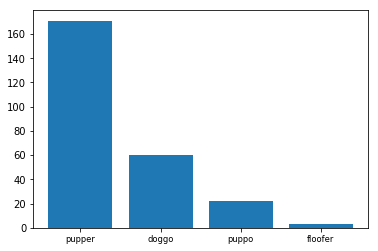

In [78]:
dog_types = df_merged_clean.dog_class.value_counts()

plt.bar(range(len(dog_types)), dog_types.values, align='center')
plt.xticks(range(len(dog_types)), dog_types.index.values, size='small')
plt.show()

### pupper dog class has the highest score of 165 and floofer dog class has the lowest with a score of 2

# investigate the relation of ratings over time

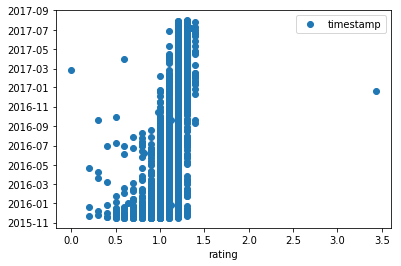

In [79]:
df_merged_clean['rating'] = df_merged_clean['rating_numerator'] / df_merged_clean['rating_denominator']
df_merged_clean.plot(x='rating', y='timestamp', style='o')



### rating 3.5 is considered an outlier and should be removed

# count of top 10 classified breeds in the dataset

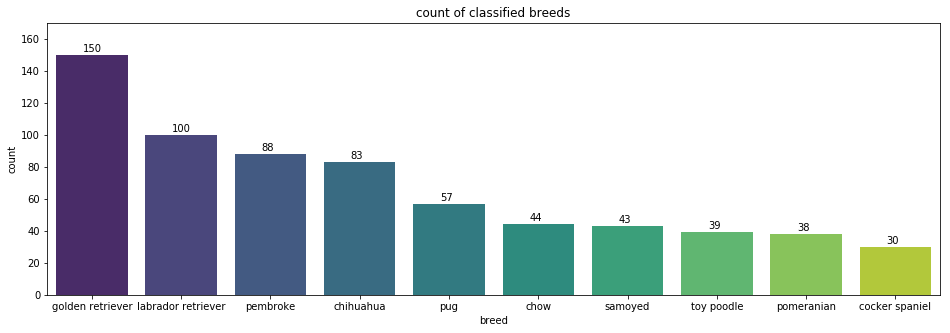

In [80]:
fig, ax = plt.subplots(figsize = (16,5))
ax = sns.countplot(x = "breed", data = df_merged_clean, order=df_merged_clean.breed.value_counts().iloc[:10].index, palette = "viridis")
ax.set_title("count of classified breeds");

ax.set_ylim(0, 170)
#https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+2))

# Investigate which breed got the most retweets and favorites.

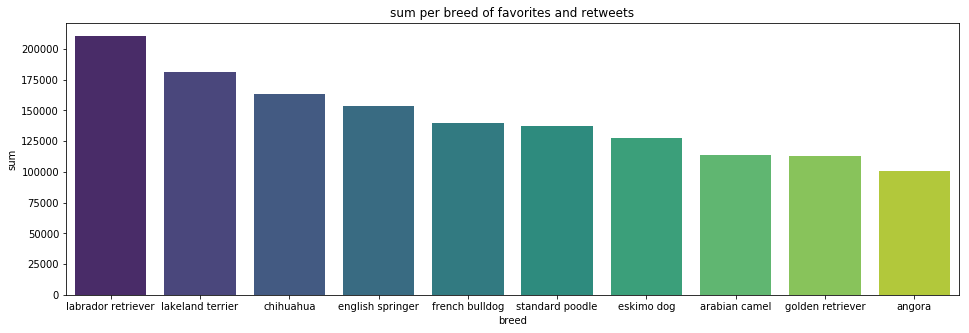

In [81]:
df_merged_clean["sum"] = df_merged_clean["retweet_count"] + df_merged_clean["favorite_count"]
values = df_merged_clean.sort_values("sum", ascending = False).head(10)
fig, ax = plt.subplots(figsize = (16,5))
ax = sns.barplot(x = "breed", y = "sum", data = df_merged_clean.sort_values("sum", ascending=False).iloc[:10], palette = "viridis")
ax.set_title("sum per breed of favorites and retweets");

In [82]:
df_merged_clean['rating'].describe()

count    1750.000000
mean     1.088035   
std      0.186992   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      3.428571   
Name: rating, dtype: float64

In [92]:
df_merged_clean['rating_numerator'].describe()

count    1750.000000
mean     11.441017  
std      7.795983   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      165.000000 
Name: rating_numerator, dtype: float64

In [93]:
df_merged_clean['rating_denominator'].describe()

count    1750.000000
mean     10.514857  
std      6.818362   
min      2.000000   
25%      10.000000  
50%      10.000000  
75%      10.000000  
max      150.000000 
Name: rating_denominator, dtype: float64

# Investigate the count of tweets for each month

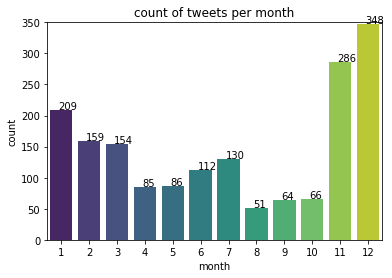

In [91]:
df_merged_clean["month"] = df_merged_clean["timestamp"].apply(lambda x: x.month)

ax = sns.countplot(x = df_merged_clean["month"], palette = "viridis")
ax.set_title("count of tweets per month");

ax.set_ylim(0,350)

#https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+1.5))

In [108]:
br = df_merged_clean.groupby('breed')["conf","rating"].mean()
br.sort_values("conf",ascending = False).head(10)

,conf,rating
breed,,
komondor,0.972531,1.100000
clumber,0.946718,1.127000
brittany spaniel,0.874545,1.042857
keeshond,0.844431,1.025000
bull mastiff,0.815618,1.040000
bernese mountain dog,0.801816,1.120000
french bulldog,0.770627,1.126923
pug,0.757663,1.031579
pomeranian,0.743606,1.115132
